In [89]:
#Import
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from tqdm import tqdm
import geopandas as gpd
import ast
from scipy import stats
from helpers import *
import statsmodels.formula.api as smf
import patsy
import networkx as nx

In [90]:
#Open Movie dataFrame
CMU_movie_df = pd.read_csv('data/movie.metadata.tsv', names = ['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date',
                                                   'Movie box office revenue','Movie runtime','Movie languages (Freebase ID:name tuples)',
                                                   'Movie countries (Freebase ID:name tuples)','Movie genres (Freebase ID:name tuples)'],sep='\t')
CMU_movie_df['Movie release date']=pd.to_datetime(CMU_movie_df['Movie release date'], format='%Y-%m-%d', errors='coerce')
CMU_movie_df['year'] = CMU_movie_df['Movie release date'].dt.year
# Display the first few rows of the dataframe
print('CMU Movies dataset has', len(CMU_movie_df), 'entries')
CMU_movie_df.head()

CMU Movies dataset has 81741 entries


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0


In [91]:
bechdel_test_df = pd.read_csv("data/df_bech_with_wikiID.csv")
bechdel_test_df

,Unnamed: 0,imdbid,year,rating,id,title,WikiID
0,0,3155794.0,1874,0,9602,Passage de Venus,47863608.0
1,1,14495706.0,1877,0,9804,La Rosace Magique,385718.0
2,2,2221420.0,1878,0,9603,Sallie Gardner at a Gallop,26044155.0
3,3,12592084.0,1878,0,9806,Le singe musicien,385718.0
4,4,7816420.0,1881,0,9816,Athlete Swinging a Pick,60115.0
...,...,...,...,...,...,...,...
10131,10131,19623240.0,2023,3,10995,Winnie-the-Pooh: Blood and Honey,70882162.0
10132,10132,1695843.0,2023,3,10996,Haunted Mansion,67472411.0
10133,10133,11820950.0,2023,3,11009,"Portable Door, The",72936663.0
10134,10134,17009710.0,2023,3,11010,Anatomie d&#39;une chute,73608937.0


In [92]:
df = pd.merge(bechdel_test_df, CMU_movie_df, left_on='WikiID', right_on='Wikipedia movie ID', how='inner')
print('The merged Bechdel movie dataset has', len(df), 'movies')
print(100*round((len(df)/len(bechdel_test_df)),2),'% of Bechdel movies are in the merged dataset')

The merged Bechdel movie dataset has 5816 movies
56.99999999999999 % of Bechdel movies are in the merged dataset


In [93]:
df.head()

,Unnamed: 0,imdbid,year_x,rating,id,title,WikiID,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),year_y
0,2,2221420.0,1878,0,9603,Sallie Gardner at a Gallop,26044155.0,26044155,/m/0b6f62m,Sallie Gardner at a Gallop,NaT,NaN,0.05,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN
1,13,392728.0,1888,0,8040,Roundhay Garden Scene,1082508.0,1082508,/m/044ggd,Roundhay Garden Scene,1888-01-01,NaN,0.03,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1888.0
2,18,466876.0,1889,0,9619,"Leisurely Pedestrians, Open Topped Buses and H...",12170539.0,12170539,/m/02vs8rb,"Leisurely Pedestrians, Open Topped Buses and H...",1889-01-01,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1889.0
3,19,2116898.0,1889,0,9945,Hyde Park Corner,12170539.0,12170539,/m/02vs8rb,"Leisurely Pedestrians, Open Topped Buses and H...",1889-01-01,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1889.0
4,20,361921.0,1890,0,9617,"Monkeyshines, No. 1",6431996.0,6431996,/m/0g53t3,"Monkeyshines, No. 1",1890-01-01,NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}",1890.0


In [94]:
df = df.drop(['Unnamed: 0', 'year_y', 'WikiID', 'Movie release date'], axis=1)
df.head()

,imdbid,year_x,rating,id,title,Wikipedia movie ID,Freebase movie ID,Movie name,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
0,2221420.0,1878,0,9603,Sallie Gardner at a Gallop,26044155,/m/0b6f62m,Sallie Gardner at a Gallop,NaN,0.05,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
1,392728.0,1888,0,8040,Roundhay Garden Scene,1082508,/m/044ggd,Roundhay Garden Scene,NaN,0.03,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
2,466876.0,1889,0,9619,"Leisurely Pedestrians, Open Topped Buses and H...",12170539,/m/02vs8rb,"Leisurely Pedestrians, Open Topped Buses and H...",NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
3,2116898.0,1889,0,9945,Hyde Park Corner,12170539,/m/02vs8rb,"Leisurely Pedestrians, Open Topped Buses and H...",NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
4,361921.0,1890,0,9617,"Monkeyshines, No. 1",6431996,/m/0g53t3,"Monkeyshines, No. 1",NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}"


In [95]:
df.rename(columns={'year_x': 'year'}, inplace=True)

In [96]:
df.head()

,imdbid,year,rating,id,title,Wikipedia movie ID,Freebase movie ID,Movie name,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
0,2221420.0,1878,0,9603,Sallie Gardner at a Gallop,26044155,/m/0b6f62m,Sallie Gardner at a Gallop,NaN,0.05,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
1,392728.0,1888,0,8040,Roundhay Garden Scene,1082508,/m/044ggd,Roundhay Garden Scene,NaN,0.03,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
2,466876.0,1889,0,9619,"Leisurely Pedestrians, Open Topped Buses and H...",12170539,/m/02vs8rb,"Leisurely Pedestrians, Open Topped Buses and H...",NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
3,2116898.0,1889,0,9945,Hyde Park Corner,12170539,/m/02vs8rb,"Leisurely Pedestrians, Open Topped Buses and H...",NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
4,361921.0,1890,0,9617,"Monkeyshines, No. 1",6431996,/m/0g53t3,"Monkeyshines, No. 1",NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}"


C:\Users\jehq9\AppData\Local\Temp\ipykernel_16412\2088247.py:6: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




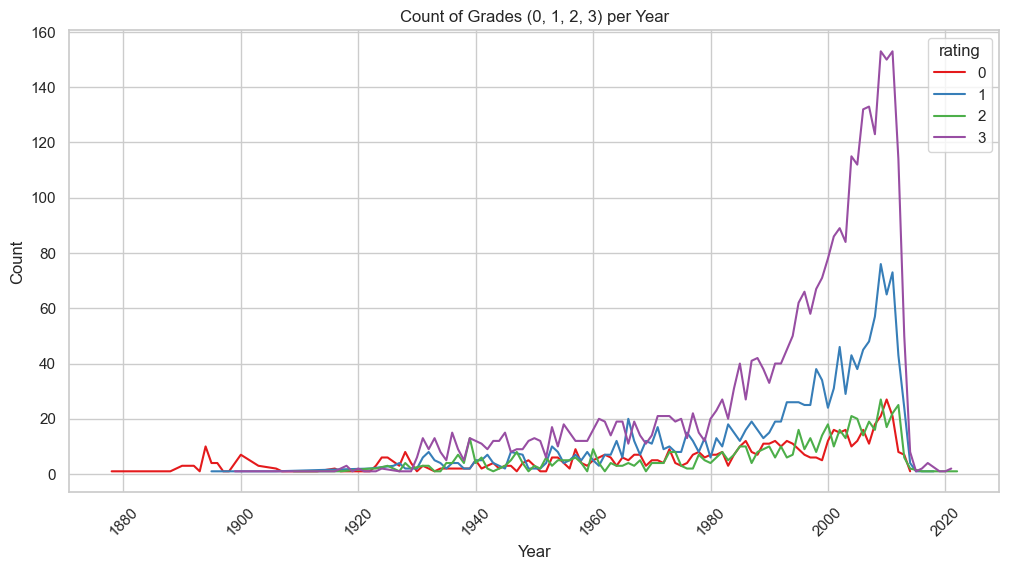

In [97]:
#Plot Grades per year 
sns.set(style="whitegrid")

# Create a line plot with counts
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='rating', hue='rating', estimator='count', data=df, ci=None,palette='Set1')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Count of Grades (0, 1, 2, 3) per Year')

# Display the plot
plt.show()

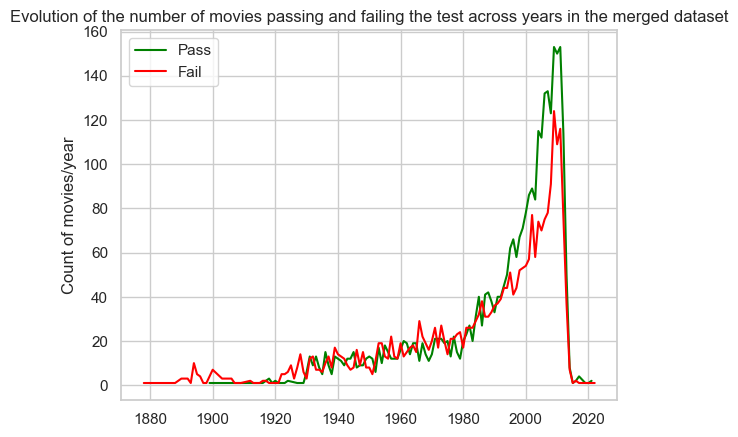

In [98]:
df['result'] = df['rating']==3
df['result'] = df['result'].astype(int)

#Count Passing and failing per year
pass_year = df[df['result'] == 1].groupby('year').count()
fail_year = df[df['result'] == 0].groupby('year').count()
plt.plot(pass_year.index,pass_year['id'], color='green', label ='Pass')
plt.plot(fail_year.index, fail_year['id'], color = 'red', label = 'Fail')
plt.ylabel('Count of movies/year')
plt.title('Evolution of the number of movies passing and failing the test across years in the merged dataset')
plt.legend()

Text(0.5, 1.0, 'Proportion of movies passing the Bechdel test each year')

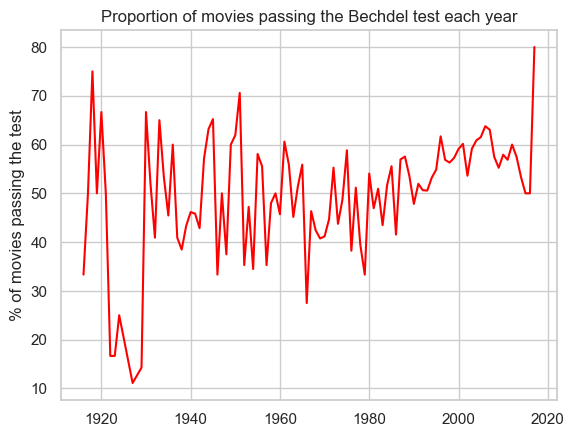

In [99]:
#Fraction of movies passing the test
pass_fail = pd.merge(pass_year, fail_year, left_on='year', right_on='year', how='inner')
plt.plot(pass_fail.index,(pass_fail['id_x']/(pass_fail['id_y']+pass_fail['id_x']))*100, color='red')
plt.ylabel('% of movies passing the test')
plt.title('Proportion of movies passing the Bechdel test each year')

In [100]:
percentage_year = (pass_fail['id_x']/(pass_fail['id_y']+pass_fail['id_x']))*100
stats.spearmanr(pass_fail.index, percentage_year)

SignificanceResult(statistic=0.34108911560345156, pvalue=0.000550479598119025)

In [101]:
# Convert the string representation of tuples to actual tuples
df['genres'] = df['Movie genres (Freebase ID:name tuples)'].apply(ast.literal_eval)

# Explode the 'genres' column to create separate rows for each genre tuple
merged_exploded = df.explode('genres')
unique_ids_genre = merged_exploded['genres'].unique()

#List with IDs of the 10 most present genres in the merged dataset
top10_genres = merged_exploded.groupby('genres').count().sort_values(by='id',ascending=False).index[0:10]
top10_genres

#Filter Merged with top 10
top10_merged = merged_exploded[merged_exploded['genres'].isin(top10_genres)]

In [102]:
df = df.drop(['Movie genres (Freebase ID:name tuples)'], axis=1)

In [103]:
df.head()

,imdbid,year,rating,id,title,Wikipedia movie ID,Freebase movie ID,Movie name,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),result,genres
0,2221420.0,1878,0,9603,Sallie Gardner at a Gallop,26044155,/m/0b6f62m,Sallie Gardner at a Gallop,NaN,0.05,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}",0,"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen..."
1,392728.0,1888,0,8040,Roundhay Garden Scene,1082508,/m/044ggd,Roundhay Garden Scene,NaN,0.03,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}",0,"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen..."
2,466876.0,1889,0,9619,"Leisurely Pedestrians, Open Topped Buses and H...",12170539,/m/02vs8rb,"Leisurely Pedestrians, Open Topped Buses and H...",NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/07ssc"": ""United Kingdom""}",0,"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen..."
3,2116898.0,1889,0,9945,Hyde Park Corner,12170539,/m/02vs8rb,"Leisurely Pedestrians, Open Topped Buses and H...",NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/07ssc"": ""United Kingdom""}",0,"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen..."
4,361921.0,1890,0,9617,"Monkeyshines, No. 1",6431996,/m/0g53t3,"Monkeyshines, No. 1",NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}",0,{'/m/06ppq': 'Silent film'}


In [104]:
#Genre IDs are not interpretable, we create a dictionnary with genre names associated to IDs
top10_dic = {"/m/01jfsb": "Thriller", "/m/03npn": "Horror",
             "/m/0lsxr":"Crime Fiction", "/m/03k9fj":"Adventure",
             "/m/07s9rl0":"Drama","/m/02l7c8":"Romance Film",
             "/m/01z4y":"Comedy","/m/03q4nz": "World cinema",
             "/m/03btsm8":"Action/Adventure","/m/02kdv5l":"Action",
            "/m/0219x_": "Indie"}

C:\Users\jehq9\AppData\Local\Temp\ipykernel_16412\1555576718.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'Number of movies in the merged dataset')

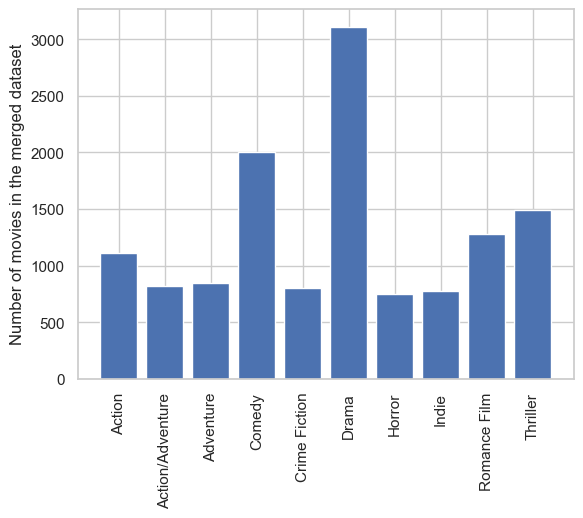

In [105]:
#Barplot showing the top 10 genres
top10_merged['genres'] = top10_merged['genres'].replace(top10_dic) #Assign genre names

plt.bar(top10_merged.groupby('genres').count().index,top10_merged.groupby('genres').count()['id'])
plt.xticks(rotation=90)
plt.ylabel('Number of movies in the merged dataset')

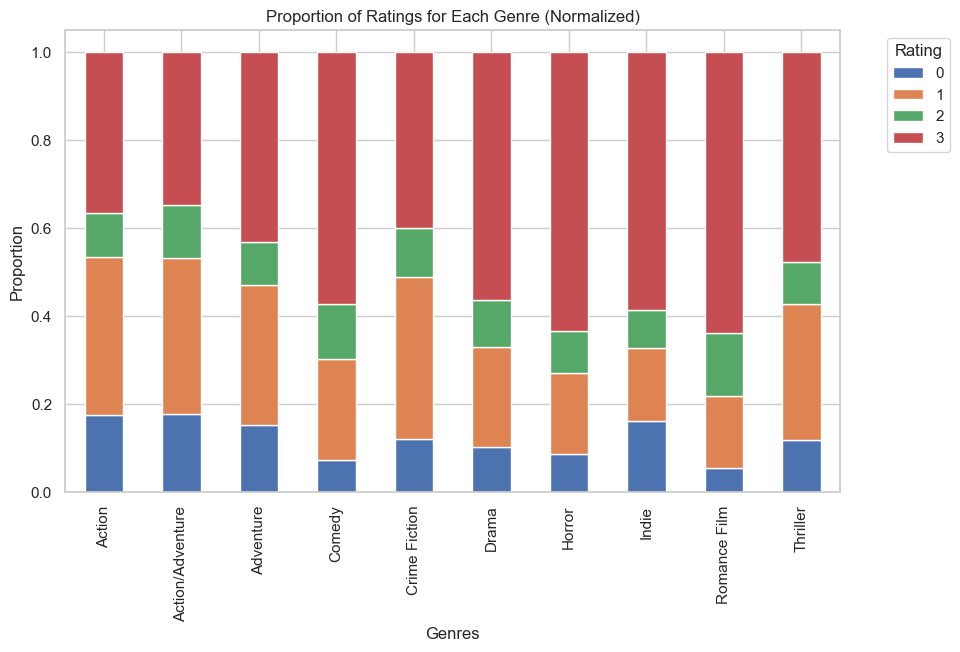

In [106]:
# Group by 'genres' and 'rating', and calculate proportions
genre_rating_proportions = top10_merged.groupby(['genres', 'rating']).size() / top10_merged.groupby('genres').size()

# Reset the index to make it a DataFrame
genre_rating_proportions = genre_rating_proportions.reset_index(name='proportion')

# Pivot the DataFrame to have 'rating' as columns
genre_rating_proportions_pivot = genre_rating_proportions.pivot(index='genres', columns='rating', values='proportion')

# Plotting
ax = genre_rating_proportions_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_ylabel('Proportion')
ax.set_xlabel('Genres')
ax.set_title('Proportion of Ratings for Each Genre (Normalized)')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [107]:
df['genres'] = df['genres'].apply(lambda x: list(x.values()) if isinstance(x, dict) else [])
df['genres'] = df['genres'].apply(lambda x: ', '.join(map(str, x)))

df['countries'] = df['Movie countries (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))  
df['countries'] = df['countries'].apply(lambda x: x[0] if x else None)

df['languages'] = df['Movie languages (Freebase ID:name tuples)'].apply(ast.literal_eval).apply(lambda x: list(x.values()) if isinstance(x, dict) else [])
df['languages'] = df['languages'].apply(lambda x: ', '.join(map(str, x)))


In [108]:
df = df.drop(['Movie countries (Freebase ID:name tuples)', 'Movie languages (Freebase ID:name tuples)'], axis=1)

In [109]:
film_per_country = pd.DataFrame()
film_per_country[['countries','count']] = df['countries'].value_counts().reset_index()
film_per_country.head()

,countries,count
0,United States of America,4145
1,France,442
2,United Kingdom,288
3,Japan,176
4,Spain,70


In [110]:
pass_count_by_country = df[df['result'] == 1].copy().groupby('countries')['result'].sum().reset_index()

# Sort the DataFrame to extract the top 10 countries
top_countries_df = pass_count_by_country.sort_values(by='result', ascending=False)

In [111]:
count_result_countries = pd.merge(film_per_country, top_countries_df
                                  , on='countries', how='inner')

count_result_countries['ratio'] = count_result_countries['result']/count_result_countries['count']

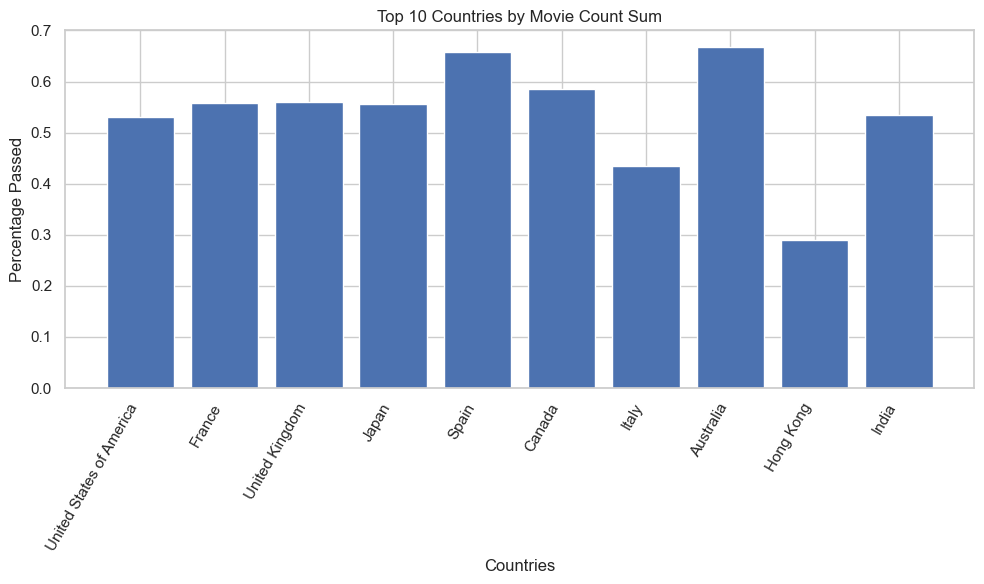

In [112]:
top_10_countries = count_result_countries.head(10)

# Create a bar plot of the percentages for these ten countries
plt.figure(figsize=(10, 6))
plt.bar(top_10_countries['countries'], top_10_countries['ratio'])
plt.xlabel('Countries')
plt.ylabel('Percentage Passed')
plt.title('Top 10 Countries by Movie Count Sum')
plt.xticks(rotation=60, ha='right')

# Set y-axis limits
plt.ylim(0.0, 0.7)

plt.tight_layout()
plt.show()

In [113]:
#Check the proportion of NaNs values in the column 'Movie box office revenue' in the merged dataframe
nan_sum = df['Movie box office revenue'].isna().sum()
print("Proportion of NaN values in 'Movie box office revenue': {:.2%}".format(nan_sum/len(df)))

Proportion of NaN values in 'Movie box office revenue': 43.62%


In [114]:
#Create a copy without the Nans values of revenues
revenue_df = df.copy().dropna(subset=['Movie box office revenue'])
revenue_df_pass = revenue_df[revenue_df['result']==1]

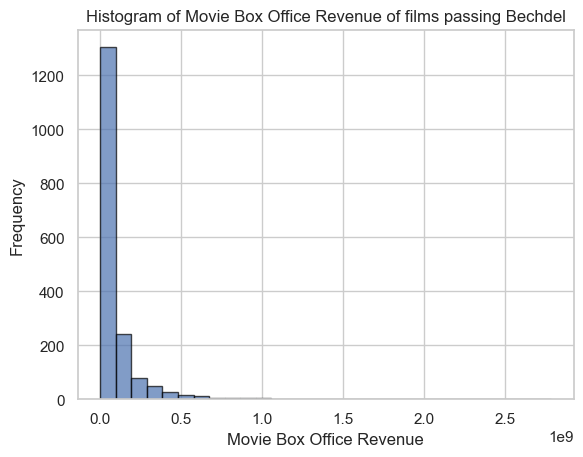

In [115]:
bins = np.linspace(revenue_df_pass['Movie box office revenue'].min()
                   , revenue_df_pass['Movie box office revenue'].max(), 30)

# Plot the histogram
plt.hist(revenue_df_pass['Movie box office revenue'], bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Movie Box Office Revenue')
plt.ylabel('Frequency')
plt.title('Histogram of Movie Box Office Revenue of films passing Bechdel')
plt.show()

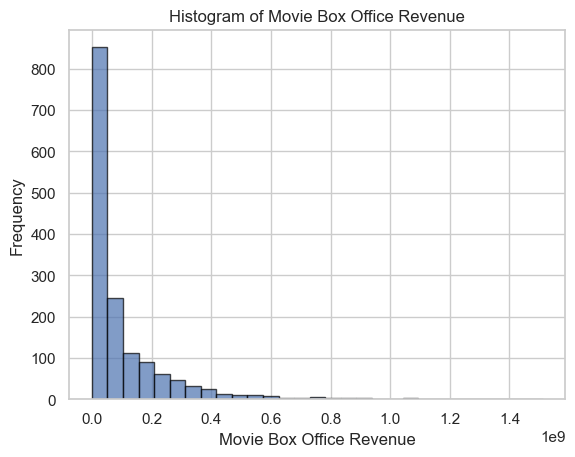

In [116]:
#Drop Na values of the bechdel fail dataframe
revenue_df_fail = revenue_df[revenue_df['result']==0]
bins = np.linspace(revenue_df_fail['Movie box office revenue'].min()
                   , revenue_df_fail['Movie box office revenue'].max(), 30)

# Plot the histogram
plt.hist(revenue_df_fail['Movie box office revenue'], bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Movie Box Office Revenue')
plt.ylabel('Frequency')
plt.title('Histogram of Movie Box Office Revenue')
plt.show()

C:\Users\jehq9\AppData\Local\Temp\ipykernel_16412\3857572493.py:8: RuntimeWarning:

invalid value encountered in divide



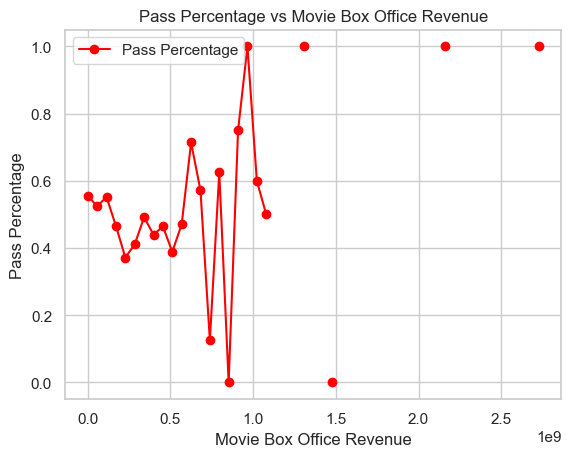

In [117]:
bins = np.linspace(min(min(revenue_df_fail['Movie box office revenue'])
                       , min(revenue_df_pass['Movie box office revenue']))
                   ,max(max(revenue_df_fail['Movie box office revenue'])
                        , max(revenue_df_pass['Movie box office revenue'])),50)

# Calculate the percentage of films that pass for each bin
total_films_per_bin = np.histogram(revenue_df_fail['Movie box office revenue'], bins=bins)[0] + np.histogram(revenue_df_pass['Movie box office revenue'], bins=bins)[0]
pass_percentage = np.histogram(revenue_df_pass['Movie box office revenue'], bins=bins)[0] / total_films_per_bin

# Plot the line representing the percentage of films that pass for each revenue
plt.plot(bins[:-1], pass_percentage, color='red', marker='o', label='Pass Percentage')

plt.xlabel('Movie Box Office Revenue')
plt.ylabel('Pass Percentage')
plt.title('Pass Percentage vs Movie Box Office Revenue')
plt.legend()
plt.show()

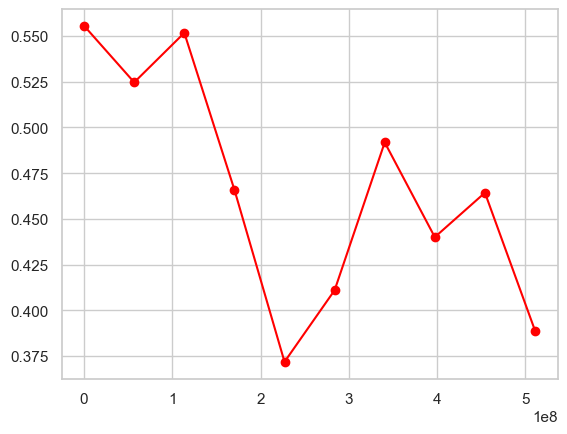

In [118]:
valid_bins = bins[:-1][total_films_per_bin >= 10]

# Create a mask to filter out movies falling within those bins
mask_pass = revenue_df_pass['Movie box office revenue'].apply(lambda x: np.searchsorted(valid_bins, x, side='right') % len(valid_bins) != 0)
mask_fail = revenue_df_fail['Movie box office revenue'].apply(lambda x: np.searchsorted(valid_bins, x, side='right') % len(valid_bins) != 0)

# Use the mask to drop movies from both dataframes
revenue_df_pass_filtered = revenue_df_pass[mask_pass]
revenue_fail_df_filtered = revenue_df_fail[mask_fail]

# Now you can proceed with plotting the pass percentage using revenue_df_filtered
pass_counts = np.histogram(revenue_df_pass_filtered['Movie box office revenue'], bins=valid_bins)[0]
total_films_per_bin_1d = total_films_per_bin[total_films_per_bin >= 10][:len(pass_counts)].ravel()

# Avoid division by zero
pass_percentage = np.divide(pass_counts, total_films_per_bin_1d, out=np.zeros_like(pass_counts, dtype=float), where=total_films_per_bin_1d != 0)

# Plot the line representing the percentage of films that pass for each valid bin
plt.plot(valid_bins[:-1], pass_percentage, color='red', marker='o', label='Pass Percentage')

In [119]:
#Spearman Test
stats.spearmanr(valid_bins[:-1], pass_percentage)

SignificanceResult(statistic=-0.6848484848484848, pvalue=0.02888279750673276)

# Part 3

In [120]:
column_names = [
    'Wikipedia movie ID',
    'Freebase movie ID',
    'Movie release date',
    'Character name',
    'Actor date of birth',
    'Actor gender',
    'Actor height (in meters)',
    'Actor ethnicity (Freebase ID)',
    'Actor name',
    'Actor age at movie release',
    'Freebase character/actor map ID',
    'Freebase character ID',
    'Freebase actor ID'
]

df_characters = pd.read_csv('data/MovieSummaries/character.metadata.tsv', delimiter='\t', quotechar='"', names=column_names, header=0)

In [121]:
df_characters = df_characters.drop(['Freebase movie ID', 'Movie release date', 'Character name'
                                    , 'Actor date of birth', 'Actor height (in meters)'
                                    , 'Actor ethnicity (Freebase ID)', 'Actor name'
                                    , 'Freebase character/actor map ID', 'Freebase character ID'
                                    , 'Freebase actor ID'], axis=1)
df_characters.head(3)

,Wikipedia movie ID,Actor gender,Actor age at movie release
0,975900,F,27.0
1,975900,M,32.0
2,975900,M,33.0


In [122]:
unique_genders = df_characters['Actor gender'].unique()

na_proportion = df_characters['Actor gender'].isna().mean()
print("Proportion de valeurs manquantes dans la colonne 'gender':", na_proportion)

Proportion de valeurs manquantes dans la colonne 'gender': 0.10120310294939956


In [123]:
df_genders = df_characters.copy().dropna(subset=['Actor gender'])

In [124]:
#Group by 'Wikipedia movie ID' and count the occurrences of each gender
gender_counts = df_genders.groupby('Wikipedia movie ID')['Actor gender'].value_counts().unstack()

# Calculate the proportion of female and male actors for each movie
gender_proportion = gender_counts.div(gender_counts.sum(axis=1), axis=0)
gender_proportion['M'] = 1-gender_proportion['F']

# Add the proportion columns to the original dataframe
df = pd.merge(df, gender_proportion, on='Wikipedia movie ID', how='inner')
df.rename(columns={'F': 'female_actor_ratio', 'M': 'male_actor_ratio'}, inplace=True)

In [125]:
#Calculate the number of female and male actors for each movie
gender_nbr = df_genders.groupby(['Wikipedia movie ID'])['Actor gender'].value_counts().unstack(fill_value=0)
gender_nbr.columns = ['female_actresses','male_actors']
gender_nbr.reset_index(inplace=True)

df = pd.merge(df, gender_nbr, on='Wikipedia movie ID', left_index=False, right_index=False, how='inner')

In [126]:
#Save them for later
df.to_csv('data/df.csv', errors='ignore')
df_characters.to_csv('data/df_characters.csv', errors='ignore')

In [127]:
#dataframe grouped by movies
df_grouped_bymovie = df.copy().groupby('Wikipedia movie ID').first().reset_index()

In [128]:
#ratio of movies with less than two actress and pass the test 
df_grouped_bymovie_missing = df_grouped_bymovie[(df_grouped_bymovie['result'] == 1) & (df_grouped_bymovie['female_actresses'] < 2)]
ratio = len(df_grouped_bymovie_missing) / len(df_grouped_bymovie)
print("Ratio of lengths:", ratio)

Ratio of lengths: 0.0443297133701264


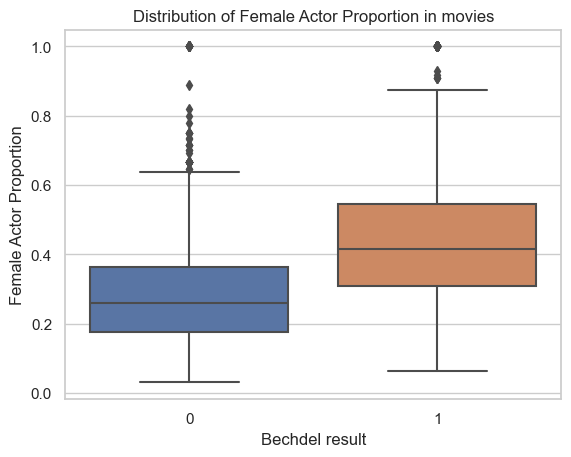

In [129]:
# Calculate the mean of 'female_actor_proportion' for each group
grouped_data = df.copy().groupby(['Wikipedia movie ID'
                                             , 'result'])['female_actor_ratio'].mean().reset_index()

# Create a box plot 
sns.boxplot(x='result', y='female_actor_ratio', data=grouped_data)

plt.xlabel('Bechdel result')
plt.ylabel('Female Actor Proportion')
plt.title('Distribution of Female Actor Proportion in movies')
plt.show()

### ADD PRODUCTION COMPANY

In [42]:
#This dataset has been downloaded using the wikipedia api in milestone 2 and stored to save time
df_production = pd.read_csv('data/df_production.csv').drop(['Unnamed: 0'], axis=1)

print(f"Proportion of NaNs in 'Production Company' column  (%): {round(100*(df_production['Production company'].isnull().sum()/len(df)))}")

Proportion of NaNs in 'Production Company' column  (%): 29


## Reduce Dimensionality of movies genres

In [43]:
df = pd.read_csv('data/df.csv').drop(['Unnamed: 0'], axis=1)
df = df.dropna(subset=['genres'], axis=0)

# Part 3.2

In [44]:
# load the dataframe df_directors that contains for a movie the name of the director and his/her gender
df_directors = pd.read_csv('data/all_directors_gender.csv', header=0)
df_directors.shape

(5056, 10)

In [45]:
df_directors.head(3)

,year,name,country,budget,gross,runtime,director,language,released,gender
0,2000,Mission: Impossible 2,['United States'],125000000,546400000,123,John Woo,['English'],2000/05/24,male
1,2000,Gladiator,"['United Kingdom', 'United States']",103000000,460500000,155,Ridley Scott,['English'],2000/05/01,male
2,2000,Cast Away,['United States'],90000000,429600000,143,Robert Zemeckis,['English'],2000/12/22,male


In [46]:
# Check for weird values in years values
years_range = df_directors['year'].unique()
print("years : ", years_range)
print("years range :", min(years_range), "-", max(years_range))
# Filter out rows where 'year' is equal to 202013
df_directors = df_directors[df_directors['year'] != 202013]
df_directors.shape
years_range = df_directors['year'].unique()
print("years :", years_range)
print("years range:", min(years_range), "-", max(years_range))

# Check for weird values in gender category
gender = df_directors['gender'].unique()
print("values for gender : ", gender)

years :  [  2000   2001   2002   2003   2004   2005   2006   2007   2008   2009
   2010   2011   2012   2013 202013   2014   2015   2016   2017   2018]
years range : 2000 - 202013
years : [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018]
years range: 2000 - 2018
values for gender :  ['male' 'female' 'unknown']


In [47]:
# load the main dataframe
df = pd.read_csv('data/df.csv').drop(['Unnamed: 0'], axis=1)

# Merge based on matching values in 'year' and 'title'
df = pd.merge(df, df_directors[['year', 'name', 'director', 'gender']], 
                     left_on=['year', 'title'], 
                     right_on=['year', 'name'], 
                     how='left')

# Drop the redundant columns
df = df.drop(['name'], axis=1)
df.rename(columns={'gender': 'director_gender'}, inplace=True)


# Filter rows with 'gender' equal to 'male' or 'female'
df_dir = df[df['director_gender'].isin(['male', 'female'])]

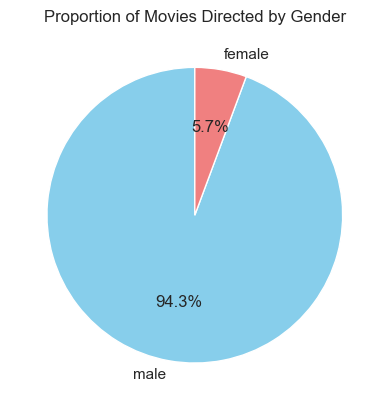

In [48]:
# Count the number of movies directed by each gender
gender_counts = df_dir['director_gender'].value_counts()

# Plot a pie chart
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Proportion of Movies Directed by Gender')

# Show the plot
plt.show()

In [49]:
gender_counts

male      1051
female      63
Name: director_gender, dtype: int64

In [50]:
# Calculate the proportions for each rating category for male directors
male_proportions = df_dir[df_dir['director_gender'] == 'male']['rating'].value_counts(normalize=True) * 100
female_proportions = df_dir[df_dir['director_gender'] == 'female']['rating'].value_counts(normalize=True) * 100

# Calculate the proportions for each rating category
directors_gender_prop = pd.merge(male_proportions, female_proportions, on=['rating'], how='outer')

<Figure size 1200x600 with 0 Axes>

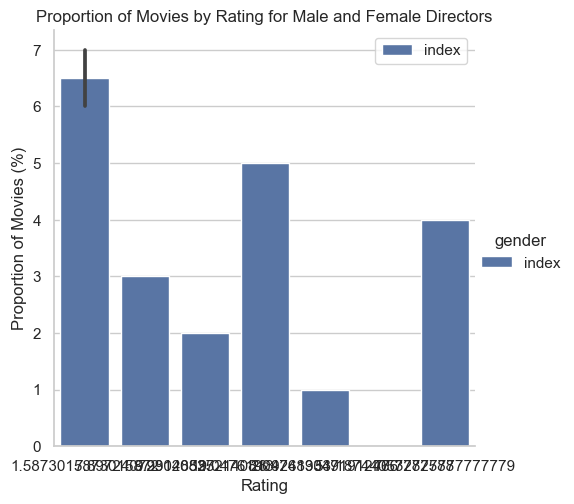

In [51]:
# Calculate the proportions for each rating category 
male_proportions = df_dir[df_dir['director_gender'] == 'male']['rating'].value_counts(normalize=True) * 100
female_proportions = df_dir[df_dir['director_gender'] == 'female']['rating'].value_counts(normalize=True) * 100

directors_gender_prop = pd.merge(male_proportions, female_proportions, on=['rating'], how='outer')
directors_gender_prop = directors_gender_prop.reset_index()

#Reset index and rename columns
directors_gender_prop = directors_gender_prop.rename(columns={ 'proportion_x': 'Male', 'proportion_y': 'Female'})
#directors_gender_prop = directors_gender_prop.reset_index(drop=True)
directors_gender_prop

directors_gender_prop = pd.melt(directors_gender_prop, id_vars='rating', var_name='gender', value_name='proportion')


# Set up the plot
plt.figure(figsize=(12, 6))

# Plot for both male and female directors
sns.catplot(x='rating', y='proportion', hue='gender', data=directors_gender_prop, kind='bar', height=5, aspect=1)

plt.xlabel('Rating')
plt.ylabel('Proportion of Movies (%)')
plt.title('Proportion of Movies by Rating for Male and Female Directors')

plt.legend()
plt.show()

# Part 3.3

In [52]:
headers_character = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", "Actor height (in meters)", "Actor ethnicity (Freebase ID)", "Actor name", "Actor age at movie release", "Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"]
df_characters = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t', header=None, names=headers_character)
df_characters.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l


In [53]:
actors = df_characters[df_characters['Actor gender'] == 'M']
actresses = df_characters[df_characters['Actor gender'] == 'F']

# Calculate average age for actors and actresses in each movie
avg_age_actors = actors.groupby('Wikipedia movie ID')['Actor age at movie release'].mean()
avg_age_actresses = actresses.groupby('Wikipedia movie ID')['Actor age at movie release'].mean()

# Compute the ratio for each movie
ratio = avg_age_actresses / avg_age_actors
ratio = ratio.rename('age_ratio')
df = df.merge(ratio, how='left', left_on='Wikipedia movie ID', right_on = 'Wikipedia movie ID')
df.shape

(5869, 21)

In [54]:
# Create a list of film Wikiepedia IDs with no missing values for the age of actors
movies_with_all_ages = df_characters.groupby('Wikipedia movie ID')['Actor age at movie release'].apply(lambda x: x.notna().all())

# Filter movies with all ages
movies_with_all_ages = movies_with_all_ages[movies_with_all_ages].index.tolist()

# Select movies in the list created above and with no missing values for ratings and for ratio
df_age_ratio = df[df['Wikipedia movie ID'].isin(movies_with_all_ages) & df['rating'].notna() & df['age_ratio'].notna()]
df.shape

(5869, 21)

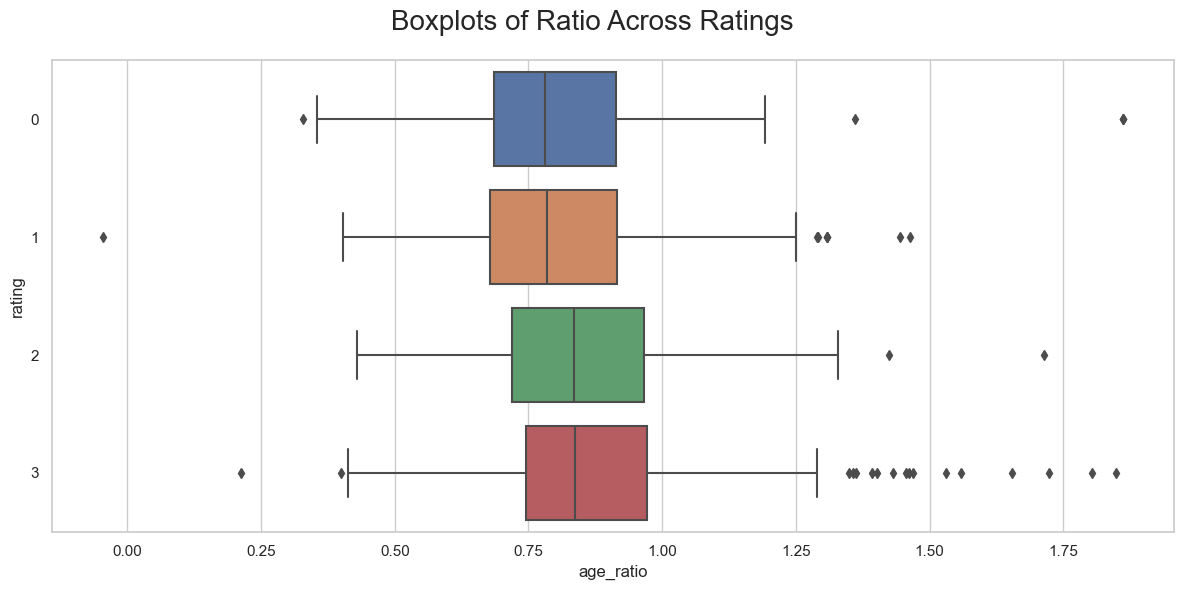

(5869, 21)

In [55]:
fig=plt.figure(figsize=(12, 6))
sns.boxplot(x=df_age_ratio['age_ratio'], y=df_age_ratio['rating'], orient='h')
    
fig.suptitle('Boxplots of Ratio Across Ratings', fontsize=20)

plt.tight_layout()

plt.show()

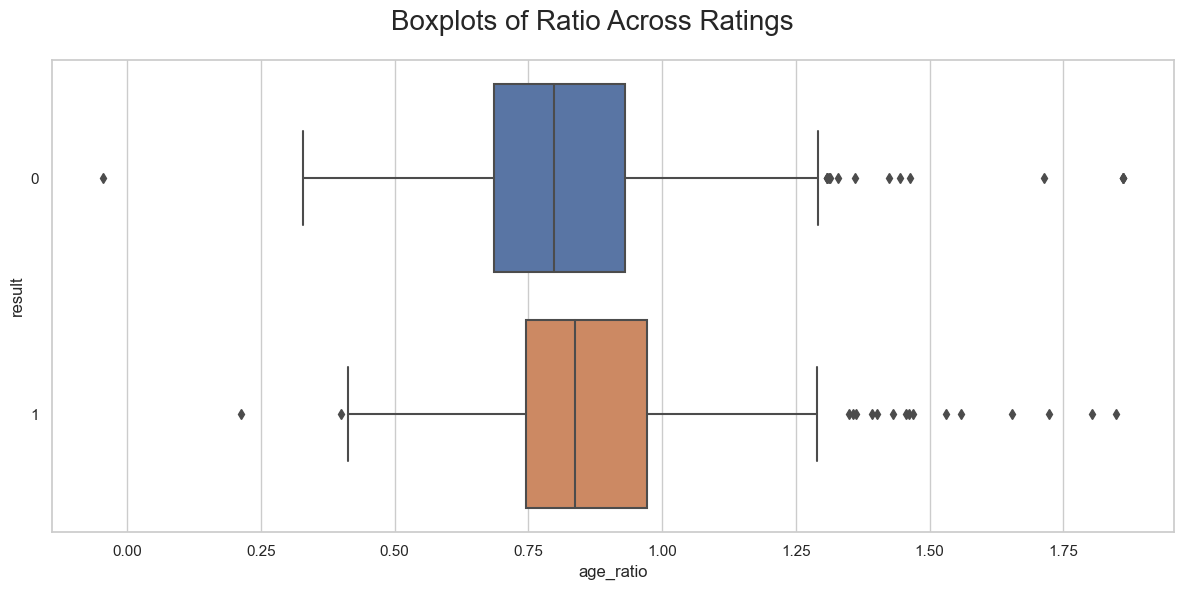

In [85]:
fig=plt.figure(figsize=(12, 6))
sns.boxplot(x=df_age_ratio['age_ratio'], y=df_age_ratio['result'], orient='h')
    
fig.suptitle('Boxplots of Ratio Across Ratings', fontsize=20)

plt.tight_layout()

plt.show()

In [142]:
# Perform a t-test
result_0 = df_age_ratio[df_age_ratio['result'] == 0]['age_ratio']
result_1 = df_age_ratio[df_age_ratio['result'] == 1]['age_ratio']

statistic, p_value = stats.ttest_ind(result_0, result_1, equal_var=False)
# Show the test result
print(f"T-test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Print the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The difference in means is statistically significant.")
else:
    print("Fail to reject the null hypothesis: The difference in means is not statistically significant.")

T-test Statistic: -3.857653992502993
P-value: 0.00012043081342872147
Reject the null hypothesis: The difference in means is statistically significant.


In [58]:
df.to_csv('data/df.csv', errors='ignore')

# Part 4

In [59]:
df = pd.read_csv('data/df.csv').drop(['Unnamed: 0'], axis=1)

In [60]:
# select variable for causality analysis
# genres not included due to very high dimensionality
df_causality = df[['result','title','year','Movie box office revenue','Movie runtime','female_actor_ratio','director_gender','age_ratio']]
df_causality = df_causality[df_causality['director_gender'].isin(['male', 'female'])]

df_causality.head(3)

,result,title,year,Movie box office revenue,Movie runtime,female_actor_ratio,director_gender,age_ratio
3045,0,Red Planet,2000,33463969.0,108.0,0.166667,male,0.797101
3047,1,American Psycho,2000,34266564.0,102.0,0.437500,female,0.882759
3048,1,Hollow Man,2000,190213455.0,119.0,0.500000,male,0.830846


In [61]:
# Get dummy variables for director gender
df_causality['director_gender'] = df_causality['director_gender'].map({'male': 1, 'female': 0})

# Pplit actresses ratio in two categories: less than 50% and more
df_causality['female_actor_binary'] = (df_causality['female_actor_ratio'] >= 0.5).astype(int)

# Convert column names to lowercase
df_causality.columns = df_causality.columns.str.lower()
# Replace spaces with underscores in column names
df_causality.columns = df_causality.columns.str.replace(' ', '_')
df_causality = df_causality.dropna()


df_causality.head(3)

,result,title,year,movie_box_office_revenue,movie_runtime,female_actor_ratio,director_gender,age_ratio,female_actor_binary
3045,0,Red Planet,2000,33463969.0,108.0,0.166667,1,0.797101,0
3047,1,American Psycho,2000,34266564.0,102.0,0.437500,0,0.882759,0
3048,1,Hollow Man,2000,190213455.0,119.0,0.500000,1,0.830846,1


In [62]:
# z-score normalisation
df_causality['movie_box_office_revenue'] = (df_causality['movie_box_office_revenue'] - df_causality['movie_box_office_revenue'].mean())/df_causality['movie_box_office_revenue'].std()
df_causality['movie_runtime'] = (df_causality['movie_runtime'] - df_causality['movie_runtime'].mean())/df_causality['movie_runtime'].std()
df_causality['age_ratio'] = (df_causality['age_ratio'] - df_causality['age_ratio'].mean())/df_causality['age_ratio'].std()
df_causality['female_actor_ratio'] = (df_causality['female_actor_ratio'] - df_causality['female_actor_ratio'].mean())/df_causality['female_actor_ratio'].std()

# min-max normalisation for years
min_year = df_causality['year'].min()
max_year = df_causality['year'].max()
df_causality['year'] = (df_causality['year'] - min_year) / (max_year - min_year)

# Create and fit logistric regression model
mod = smf.logit(formula ='female_actor_binary ~  year + movie_box_office_revenue + movie_runtime + C(director_gender) + age_ratio ', data=df_causality)
res = mod.fit()


# Extract the estimated propensity scores
df_causality['Propensity_score'] = res.predict()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.441147
         Iterations 7
                            Logit Regression Results                           
Dep. Variable:     female_actor_binary   No. Observations:                  948
Model:                           Logit   Df Residuals:                      942
Method:                            MLE   Df Model:                            5
Date:                 Fri, 22 Dec 2023   Pseudo R-squ.:                 0.06212
Time:                         18:54:58   Log-Likelihood:                -418.21
converged:                        True   LL-Null:                       -445.91
Covariance Type:             nonrobust   LLR p-value:                 1.078e-10
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.4878      0.341     -1.431      0.152    

In [63]:
def get_similarity(propensity_score1, propensity_score2):
    return 1-np.abs(propensity_score1-propensity_score2)

In [64]:
# Separate the groups with high proportion and low proportion of actresses
low_female = df_causality[df_causality['female_actor_binary'] == 0]
high_female = df_causality[df_causality['female_actor_binary'] == 1]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in low_female.iterrows():
    for treatment_id, treatment_row in high_female.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [65]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [66]:
balanced_df_all = df_causality.loc[matched]

In [67]:
# Check the number of elements left
balanced_df_all.shape

(340, 10)

In [68]:
high_female = balanced_df_all.loc[balanced_df_all['female_actor_binary'] == 1] #high proportion of actresses
low_female = balanced_df_all.loc[balanced_df_all['female_actor_binary'] == 0] #low proportion of actresses


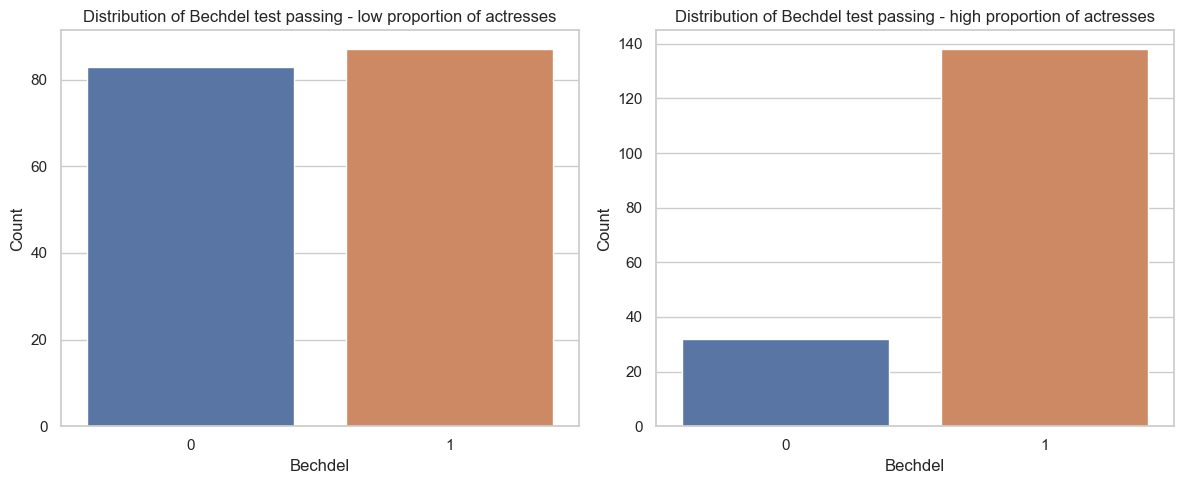

In [69]:
# plot the distribution of Bechdel for each group
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Subplot for low proportion of women
sns.countplot(data=low_female, x='result', ax=axes[0])
axes[0].set_xlabel('Bechdel')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Bechdel test passing - low proportion of actresses')

# Subplot for high proportion of women
sns.countplot(data=high_female, x='result', ax=axes[1])
axes[1].set_xlabel('Bechdel')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Bechdel test passing - high proportion of actresses')

plt.tight_layout()
plt.show()

In [70]:
result_counts = low_female['result'].value_counts(normalize=True)
print("Low percentage of actresses")
print("Percentage of movies passing and not passing Bechdel test:")
print(result_counts * 100)
print('')
result_counts = high_female['result'].value_counts(normalize=True)
print("High percentage of actresses")
print("Percentage of movies passing and not passing Bechdel test:")
print(result_counts * 100)

Low percentage of actresses
Percentage of movies passing and not passing Bechdel test:
1    51.176471
0    48.823529
Name: result, dtype: float64

High percentage of actresses
Percentage of movies passing and not passing Bechdel test:
1    81.176471
0    18.823529
Name: result, dtype: float64


Although it may be intuitive that a higher percentage of actresses in a movie means a higher probability of passing the Bechdel test, the causal analysis allows to validate this hypothesis.

### Get One-Hot encoded columns for each genres category

In [71]:
df = df.dropna(subset=['genres'], axis=0)
df_unique_genres = pd.DataFrame()
df_unique_genres['genres'] = df['genres'].copy()

In [72]:
unique_genres = df_unique_genres['genres'].copy().explode().unique()

# If you want to convert it to a list
unique_set = list(set(unique_genres))

all_genres = [genre.strip() for genres_str in unique_set for genre in genres_str.split(',')]

# Remove empty strings from the list
all_genres = [genre for genre in all_genres if genre]

# Get unique genres
unique_genres = list(set(all_genres))

#print to check the format
print(unique_genres[1:10])

['Humour', 'Political drama', 'Heist', 'Biker Film', 'Doomsday film', 'Heavenly Comedy', 'Jukebox musical', 'Splatter film', 'Religious Film']


In [73]:
type(df['genres'].values[0])

df['genres'] = df['genres'].apply(lambda x: [genre.strip() for genre in x.split(',')])

In [74]:
for genre in unique_genres:
    df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)

C:\Users\jehq9\AppData\Local\Temp\ipykernel_16412\2264692498.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
C:\Users\jehq9\AppData\Local\Temp\ipykernel_16412\2264692498.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
C:\Users\jehq9\AppData\Local\Temp\ipykernel_16412\2264692498.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

C:\Users\jehq9\AppData\Local\Temp\ipykernel_16412\2264692498.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
C:\Users\jehq9\AppData\Local\Temp\ipykernel_16412\2264692498.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
C:\Users\jehq9\AppData\Local\Temp\ipykernel_16412\2264692498.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

C:\Users\jehq9\AppData\Local\Temp\ipykernel_16412\2264692498.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
C:\Users\jehq9\AppData\Local\Temp\ipykernel_16412\2264692498.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
C:\Users\jehq9\AppData\Local\Temp\ipykernel_16412\2264692498.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

In [75]:
one_hot_country = pd.get_dummies(df['countries'])
df = pd.concat([df, one_hot_country], axis=1)
df = df.drop(['genres', 'countries'], axis=1)

In [76]:
from sklearn.preprocessing import StandardScaler


columns_to_normalize = ['year', 'Movie box office revenue', 'Movie runtime', 'female_actor_ratio',
                         'male_actor_ratio', 'male_actors', 'female_actresses', 'age_ratio']

scaler = StandardScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [77]:
ml_df = df.copy().drop(['year', 'age_ratio','imdbid', 'director', 'director_gender', 'rating', 'id', 'Wikipedia movie ID', 'Freebase movie ID'
                        , 'Movie name', 'title', 'languages', 'male_actor_ratio', 'male_actors'], axis=1)
ml_df = ml_df.dropna(subset=ml_df.columns, axis=0)

In [78]:
X = ml_df.copy().drop(['result'], axis=1)
y = ml_df.copy()['result']

#Drop eventual genres columns that has only 0 which means no films contain this genre
X = X.loc[:, (X != 0).any(axis=0)]

X.head(3)

,Movie box office revenue,Movie runtime,female_actor_ratio,female_actresses,Mumblecore,Humour,Political drama,Heist,Biker Film,Doomsday film,...,South Africa,South Korea,Spain,Sweden,Switzerland,Thailand,United Kingdom,United States of America,Weimar Republic,West Germany
21,-0.286805,3.238495,0.324480,0.639776,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
39,-0.582768,-1.753090,-0.526748,-0.373251,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
54,-0.588688,-0.985154,0.714626,-1.048602,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [79]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout
from tensorflow.keras.optimizers import *
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CatBoost classifier
catboost_classifier = CatBoostClassifier(iterations=100, depth=6, random_seed=42, verbose=False)
catboost_classifier.fit(X_train, y_train)
y_pred_catboost = catboost_classifier.predict(X_test)

#Create a Neural Network
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = RMSprop(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=False)
y_pred_nn = (model.predict(X_test) > 0.5).astype(int)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

#plt.figure(figsize=(20, 10))
#plot_tree(rf_classifier.estimators_[0], filled=True, rounded=True)
#plt.show()

y_pred_rf = rf_classifier.predict(X_test)
# Evaluate models and compare NN to Catboost
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
report_nn = classification_report(y_test, y_pred_nn)
report_catboost = classification_report(y_test, y_pred_catboost)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf}")
print("Classification Report RF:")
print(report_rf)
print(f"CatBoost Accuracy: {accuracy_catboost}")
print("Classification Report Catboost:")
print(report_catboost)
print(f"Neural Network Accuracy: {accuracy_nn}")
print("Classification Report NN:")
print(report_nn)





21/21 [==============================] - 0s 2ms/step
Random Forest Accuracy: 0.713859910581222
Classification Report RF:
              precision    recall  f1-score   support

           0       0.68      0.67      0.67       297
           1       0.74      0.75      0.75       374

    accuracy                           0.71       671
   macro avg       0.71      0.71      0.71       671
weighted avg       0.71      0.71      0.71       671

CatBoost Accuracy: 0.7078986587183308
Classification Report Catboost:
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       297
           1       0.73      0.76      0.74       374

    accuracy                           0.71       671
   macro avg       0.70      0.70      0.70       671
weighted avg       0.71      0.71      0.71       671

Neural Network Accuracy: 0.7153502235469449
Classification Report NN:
              precision    recall  f1-score   support

           0       0.71   

In [80]:
from sklearn.linear_model import LogisticRegression

#Create a Logistic Regression model
logistic_regression_model = LogisticRegression(max_iter=1000)

# Fit the model to the training data
logistic_regression_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logistic = logistic_regression_model.predict(X_test)

# Evaluate the model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f'Accuracy using Logistic Regression: {accuracy_logistic}')

Accuracy using Logistic Regression: 0.6974664679582713
